<h2><center>THE CHINESE UNIVERSITY OF HONG KONG<br /> 
    Department of Mathematics<br />
 MATH4280<br />
    Innovation and Design in Big Data Analytics</center></h2>

# Tutorial 7<a id='top'></a>

- <a href='#section1'>7.1 Compressed Sensing</a>
- <a href='#section2'>7.2 Reconstruction of a Simple Signal </a>
- <a href='#section3'>7.3 Reconstruction of an Image (a 2D Signal)</a>
- <a href='#section4'>7.4 Gradient Descent method</a>
- <a href='#section5'>7.5 Robust PCA</a>


## 7.1 Compressed Sensing
<a id='section1'></a>

We will be investigating compressed sensing (also known as compressive sensing, compressive sampling, and sparse sampling) in Python. Since the idea of compressed sensing can be applied in wide array of subjects, I’ll be focusing mainly on how to apply it in one and two dimensions to things like sounds and images. Specifically, we will show how to take a highly incomplete data set of signal samples and reconstruct the underlying sound or image. It is a very powerful technique.

### $L^{1}$ vs. $L^{2}$ Fitting

As you might know, there are many different types of norms. Perhaps the most common and widely recognized one is the $L^2$ norm:

$$\|\vec{x}\|_{2}=\left(\sum_{i=0}^{n} x_{i}^{2}\right)^{1 / 2}$$

The $L^2$ norm is nice because it is easily calculated, easily differentiated, and it has intuitive appeal (e.g., the norm of a vector is its length). A lot of very important algorithms and methods rely on the $L^2$, including least squares fitting.

That said, the $L^2$ norm isn’t the goto solution for everything. The other norms also have many interesting and useful properties. Consider the $L^1$ norm:

$$\|\vec{x}\|_{1}=\sum_{i=0}^{n}\left|x_{i}\right|$$

Instead of squaring each element, it simply takes its absolute value. Although the absolute value is annoying in the sense that it often introduces discontinuities in its derivatives, it does have some unique properties when compared to the squaring that takes place in the $L^2$ norm. Compressed sensing is all about exploiting these properties.



In [1]:
# import sys
# !{sys.executable} -m pip install cvxpy

In [2]:
!pip install cvxpy
!pip install latexify-py

You should consider upgrading via the 'C:\Users\kinla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\kinla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt

import scipy.fftpack as spfft # used in question 2
import scipy.ndimage as spimg
import scipy.misc
import cvxpy as cvx
import latexify

First what we’re going to do is create some arbitrary linear data including some noise. Let’s use the made-up equation:
$$y=\frac{1}{5} x+3+\epsilon$$
where $\epsilon$ is some normally distributed error with standard deviation $\sigma=0.1$.

In [8]:
# Set a fixed random seed for reproducibility
np.random.seed(42)

x = np.sort(np.random.uniform(0, 10, 15)) # 15 random points from 0 to 10
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x)) # 0.1 is standard deviation

In [9]:
def l1_fit(x0,x,y):
    return np.sum(np.abs(x0[0] * x + x0[1] - y)) # sum of absolute values, i.e. n1 norm

def l2_fit(x0,x,y):
    return np.sum(np.power(x0[0] * x + x0[1] - y, 2)) # sum of squares, i.e. n2 norm

# initial guess
x0 = [1.0, 1.0]

# fit L1 line fit
xopt1 = spopt.fmin(func=l1_fit, x0=[1,  1], args=(x, y))
# x0: initial guess. 
# args: the changing variable on the minimization process 

xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))


Optimization terminated successfully.
         Current function value: 1.323196
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.209548
         Iterations: 49
         Function evaluations: 95


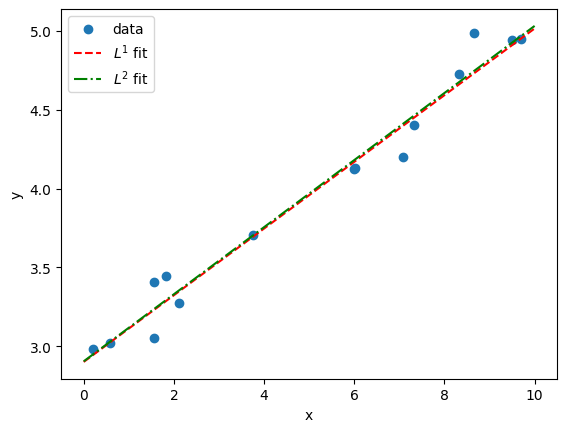

In [10]:
plt.scatter(x,y,label='data') # this line plots the dots
xx=np.linspace(0,10,100) # this line retruns even spaced 100 points from 0 to 10

plt.plot(xx,xopt1[1]+xopt1[0]*xx,'r--',label='$L^1$ fit')
plt.plot(xx,xopt2[1]+xopt2[0]*xx,'g-.',label='$L^2$ fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Now let’s fit two lines to the data samples. For the first line, we’ll use the $L_1$ norm as the criterion for a good fit; for the second line, we’ll use the $L_2$ norm.

In [11]:
# find L1 line fit
# I have done another way above, that we can specify a full function instead of lambda function. 
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y)) 
xopt1 = spopt.fmin(func=l1_fit, x0=[1,  1], args=(x, y))

# `scipy.optmize.fmin()`is a method finding minimum of a function using the downhill simplex algorithm
# `x0`: initial guess
# `args`: additional arguments to pass to the function

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 1.323196
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.209548
         Iterations: 49
         Function evaluations: 95


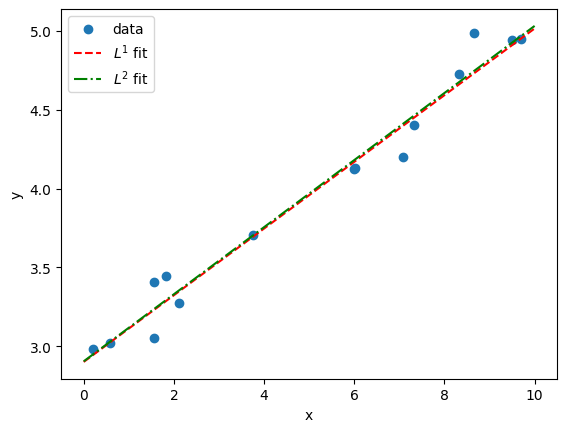

In [12]:
plt.scatter(x,y,label='data') # this line plots the dots
xx=np.linspace(0,10,100) # this line retruns even spaced 100 points from 0 to 10

plt.plot(xx,xopt1[1]+xopt1[0]*xx,'r--',label='$L^1$ fit')
plt.plot(xx,xopt2[1]+xopt2[0]*xx,'g-.',label='$L^2$ fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Notice that both of the fits seem to do a pretty good job fitting the data. Sure, they don’t line up exactly, but they both are reasonable approximations given the noise.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.

In [7]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

Optimization terminated successfully.
         Current function value: 8.015659
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 20.492913
         Iterations: 50
         Function evaluations: 96


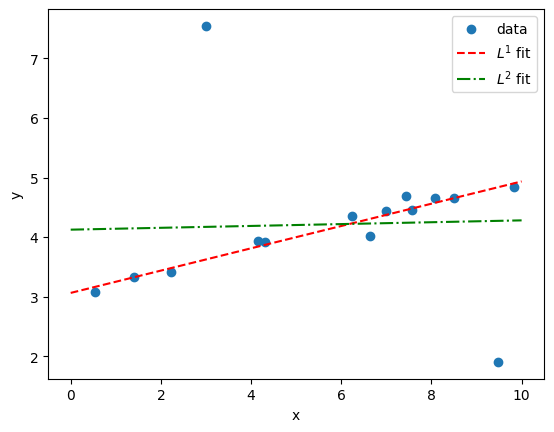

In [8]:
plt.scatter(x,y2,label='data')
xx=np.linspace(0,10,100)
plt.plot(xx,xopt12[1]+xopt12[0]*xx,'r--',label='$L^1$ fit')
plt.plot(xx,xopt22[1]+xopt22[0]*xx,'g-.',label='$L^2$ fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

When we re-plot the $L^1$ and $L^2$ fits we see something interesting: the $L^1$ fit remained true to the overall trend in the data, while the $L^2$ fit seemed to get “corrupted” by the outliers. Why does this happen? It comes down to the fact that $L^2$ error gets squared, while $L^1$ error does not. When you fit a line to data using an $L^2$ interpretation of error, the displacement of outliers has a disproportional impact because their already-big errors are get getting squared. Just look at the distance of the two outliers in our example and imagine squaring them – of course it’s not surprising that the $L^2$ line gets skewed!

However, when using an $L^1$ interpretation of error, the outliers contribute no more than their displacement. The result is a cleaner fit that more closely matches our intuition of what a good fit should look like. It’s this interesting property that opens the door to compressed sensing.

<a href='#top'>jump to the top</a>

## 6.2 Reconstruction of a Simple Signal
 <a id='section2'></a>

In this example, we will create an artificial sound wave, sample 10% of it, and reconstruct the original signal from the sample of 10%. This is one dimensional compressed sensing.

First, create a signal of two sinusoids.

In [23]:
# sum of two sinusoids
n = 5000

t = np.linspace(0, 1/8, n) # this line retruns a numpy array that contains an even spaced n points from 0 to 1/8
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho') # app;hing discrete cosine transform. norm='ortho' means that the transform is orthonormal.

In [24]:
print(type(t))

<class 'numpy.ndarray'>


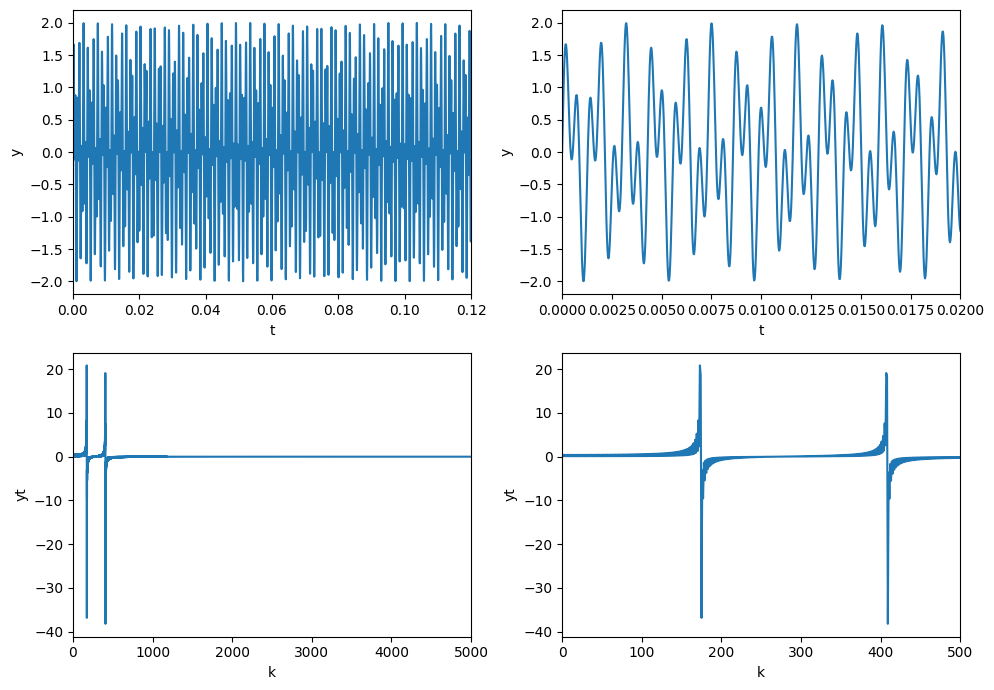

In [25]:
plt.figure(figsize=(10,7))


# original signal in 0-0.12 range: 
plt.subplot(2,2,1)
plt.plot(t,y)
plt.xlim(0,0.12)
plt.xlabel('t')
plt.ylabel('y')

# original signal in 0-0.02 range:
plt.subplot(2,2,2)
plt.plot(t,y)
plt.xlim(0,0.02)
plt.xlabel('t')
plt.ylabel('y')

# DCT coefficients in 0-5000 range:
k=np.linspace(0, n-1, n)

plt.subplot(2,2,3)
plt.plot(k,yt)
plt.xlim(0,5000)
plt.xlabel('k')
plt.ylabel('yt')

# zoom in:
plt.subplot(2,2,4)
plt.plot(k,yt)
plt.xlim(0,500)
plt.xlabel('k')
plt.ylabel('yt')

plt.tight_layout()
plt.show()

In the plots above, we see that the signal has a clear pattern, yet is non-trivial. The plots in the top row are of the signal in the temporal domain at different scales. The plots in the bottom row are of the signal in the spectral domain (i.e., the signal’s frequency content). 

Considering the frequency domain in particular, we note that the spectrum is mostly zero except for the two spikes representing the two sine frequencies.

Now imagine sampling 10% of the temporal signal (see below). You’d have a data set that, to the naked eye, would look like nonsense. The underlying signal is would still be the same, as would be its frequency content (mostly zeros, with the exception of two spikes). One might ask if it is somehow possible to extract those two dominant frequencies from the incomplete data so that we might reconstruct the signal? The answer is yes!



In [26]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices

ri.sort() # sorting not strictly necessary, but convenient for plotting
# create numpy arrays for those red dots
t2 = t[ri]
y2 = y[ri]

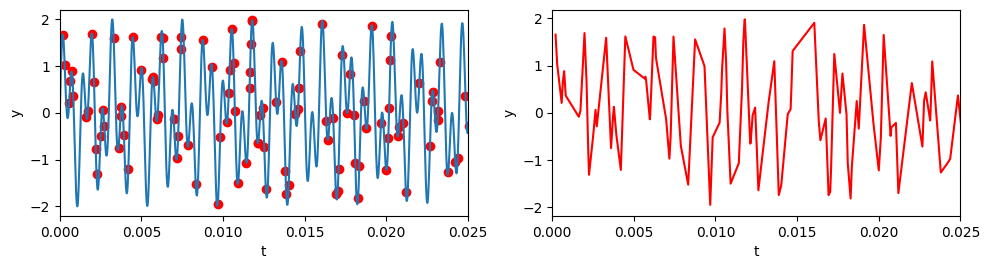

In [27]:
plt.figure(figsize=(10,5))


plt.subplot(2,2,1)
plt.plot(t,y) # original signals
plt.scatter(t2,y2,color='r') # red dots
plt.xlim(0,0.025)
plt.xlabel('t')
plt.ylabel('y')

plt.subplot(2,2,2)
plt.plot(t2,y2,'r') # interpolated signal
plt.xlim(0,0.025)
plt.xlabel('t')
plt.ylabel('y')

plt.tight_layout()
plt.show()

Compressed sensing in this context is made possible by the fact that the signal’s frequency content is highly sparse. This is where the $L^1$ norm comes into play. What we want to do is, out of all possible signals, locate the simplest one that matches up with the known data. In other words, we want to use a minimization routine to find a set of frequencies satisfying two conditions: (a) the underlying signal matches up exactly (or as closely as possible) with that of our data; and (b) the $L^1$ norm of the frequencies is minimized. Such a routine will yield a sparse solution – exactly what we want.

In Python, there are a couple of ways to accomplish this. Perhaps the easiest is to utilize the convex optimization library `CVXPY`. Use the code below to minimize the norm of the signal’s frequencies with the constraint that candidate signals should match up exactly with our incomplete samples.

In [28]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0) #discrete cosine transform
A = A[ri]

# do L1 optimization - below is constructing a convex optimization problem: 
vx = cvx.Variable(n)
# vx representing an n-dimensional vecor that the optimization problem will solve for
objective = cvx.Minimize(cvx.norm(vx, 1))
# cvx.norm(vx, 1) is the L1 norm of vx.
constraints = [A*vx == y2] 

prob = cvx.Problem(objective, constraints)

result = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 06 02:47:40 AM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 06 02:47:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 06 02:47:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 06 02:47:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 06 02:47:40 AM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 06 02:47:40 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

c:\Users\kinla\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Oct 06 02:47:43 AM: Applying reduction ECOS
(CVXPY) Oct 06 02:47:44 AM: Finished problem compilation (took 4.129e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 06 02:47:44 AM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Oct 06 02:48:43 AM: Problem status: optimal
(CVXPY) Oct 06 02:48:43 AM: Optimal value: 3.634e+02
(CVXPY) Oct 06 02:48:43 AM: Compilation took 4.129e+00 seconds
(CVXPY) Oct 06 02:48:43 AM: Solver (including time spent in interface) took 5.896e+01 seconds


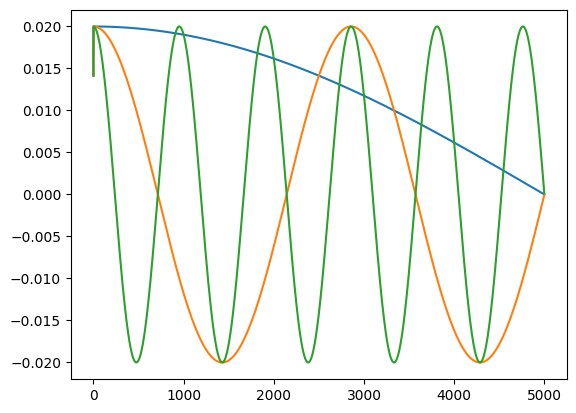

In [29]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)

# A = A[ri]
# plt.plot(A)
plt.plot(A[0])
plt.plot(A[3])
plt.plot(A[10])

You might be asking: what is that A matrix? Well, it’s the key to the whole party. Let me explain.

In order to perform the minimization, we must somehow finagle our problem into a linear system of equations:
$$Ax=b$$

Specifically, we want to derive a matrix $A$ that can be multiplied with a solution candidate $x$ to yield $b$, a vector containing the data samples. In the context of our current problem, the candidate solution $x$ exists in the frequency domain, while the known data b exists in the temporal domain. Clearly, the matrix $A$ performs both a sampling and a transformation from spectral to temporal domains.

Compressed sensing really comes down to being able to correctly derive the $A$ operator. Fortunately, there's a methodology. Start off by letting $f$ be the target signal in vector form (if your signal is 2-dimensional or higher, flatten it) and $\phi$ be the sampling matrix. Then:
$$b=\phi f$$
Now let $\psi$ be the matrix that transforms a signal from the spectral domain to the temporal domain. Given the
solution $x$ in the frequency domain, it follows that:
$$\psi x=f$$
Combining the two equations yields:
$$A x=b \quad \text{ where } A \equiv \phi \psi$$

So, $A$ is simply made up of rows sampled from the domain transform matrix $\psi$. The $\psi$ matrix is easy to construct - it is the inverse discrete cosine transform acting upon the columns of the identity matrix. The matrix product $\psi x$ is the equivalent to doing `idct(x)`

Now that we’ve constructed the $A$ matrix and run the minimization, we can reconstruct the signal by transforming the solution out of the frequency domain and back into the temporal. Below, on the left, is the original signal and its frequency content. On the right is our $L^1$ approximation. I’d say that’s pretty good for only using 10% of the data!

In [33]:
# reconstruct signal
x = np.array(vx.value)
x_alt = x.copy()

x = np.squeeze(x) # why we squeeze x? it is not an important step. I illustrated in subplot 3 and 6.
sig = spfft.idct(x, norm='ortho', axis=0)
sig_alt = spfft.idct(x_alt, norm='ortho', axis=0)

diff = sig_alt - sig

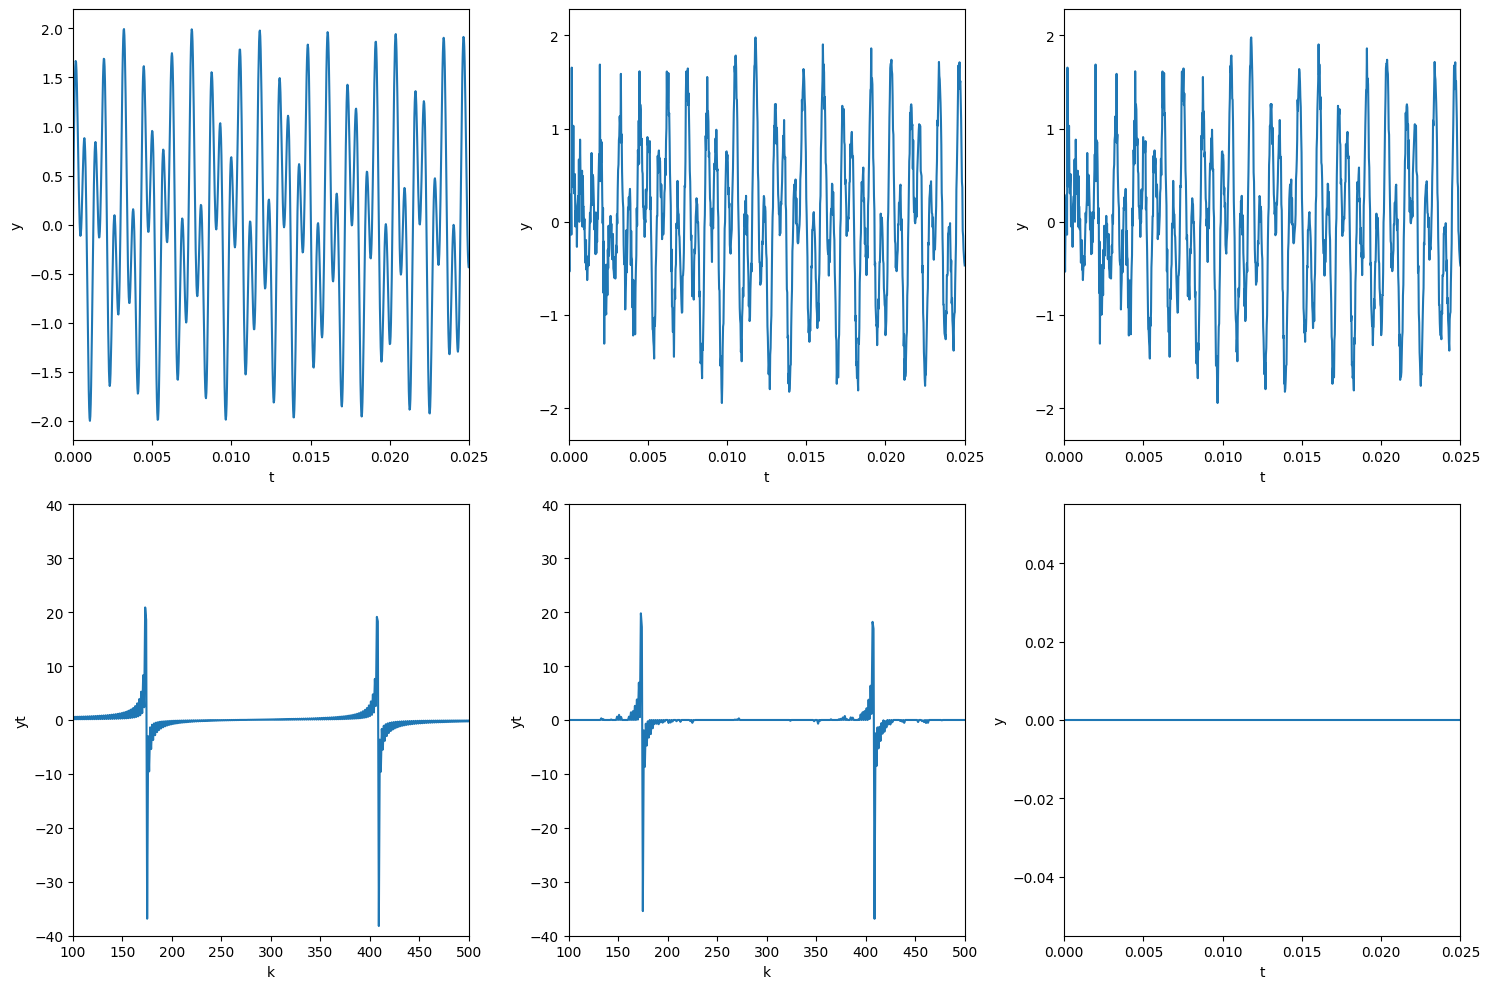

In [34]:
# original signal
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.plot(t, y)
plt.xlim(0, 0.025)
plt.xlabel('t')
plt.ylabel('y')

# restored signal
plt.subplot(2, 3, 2)
plt.plot(t, sig)
plt.xlim(0, 0.025)
plt.xlabel('t')
plt.ylabel('y')

# restored signal
plt.subplot(2, 3, 3)
plt.plot(t, sig_alt)
plt.xlim(0, 0.025)
plt.xlabel('t')
plt.ylabel('y')

k = np.linspace(0, n-1, n)

plt.subplot(2, 3, 4)
plt.plot(k, yt)
plt.xlim(100, 500)
plt.ylim(-40, 40)
plt.xlabel('k')
plt.ylabel('yt')

# L1 normalized coefficients
plt.subplot(2, 3, 5)
plt.plot(k, vx.value)
plt.xlim(100, 500)
plt.ylim(-40, 40)
plt.xlabel('k')
plt.ylabel('yt')

# restored signal
plt.subplot(2, 3, 6)
plt.plot(t, diff)
plt.xlim(0, 0.025)
plt.xlabel('t')
plt.ylabel('y')

plt.tight_layout()
plt.show()


One problem that stands out is that the quality of the reconstruction degrades noticeably at and around $t=0$. This is probably due to our sample interval violating the periodic boundary condition requirements of the cosine transform. Of course, given an arbitrary signal sample without any prior knowledge of its nature, it would be hard not to violate periodic boundary conditions. The good news is that now we have some very clear indications of the true signal’s frequencies. If desired, we could go back and resample the signal within an interval that satisfies periodic boundaries.

<a href='#top'>jump to the top</a>

## 7.3 Reconstruction of an Image (a 2D Signal) <a id='section3'></a>

Now let’s use what we learned from the 1-dimensional case to do compressed sensing in 2-dimensions. This is where the real fun begins because we can now try and reconstruct images.

Below, we will use exactly the same methodology as before to randomly sample and reconstruct the image Waterfall by M. C. Escher (approx. 1200 by 1600 pixels). Due to memory limitations imposed by the $A$ matrix, we’ll start off by considering a downsized version of the image (approx. 50 by 65 pixels). In the section that follows we’ll extend the routine to handle large images.

Note that SciPy doesn’t provide 2D versions of `dct` or `idct`. However, they can be easily constructed by recognizing that the 2D discrete cosine transform is nothing more than a `dct` acting upon the rows of $x$ followed by a second `dct` action upon its columns (or vice versa):

$$\operatorname{dct}\left(d c t\left(x^{T}\right)^{T}\right) \equiv d c t\left(d c t(x)^{T}\right)^{T}$$

As a personal preference, I like to tell SciPy’s `dct` and `idct` methods to act on the columns of a matrix (as opposed to the default behavior of acting on the rows). First of all, this keeps the Python code consistent with that of MATLAB. Second, it makes building matrix operators more intuitive (to me at least). For example, if we let $Y$ be an $m$ by $n$ matrix, with $I_{m}$ and $I_{n}$ being identity matrices of size $m$ and $n$ respectively, then
$$\operatorname{dct}(Y, \text{ axis }=0) \equiv \operatorname{dct}\left(I_{m},\right.\text{ axis }\left.=0\right) \cdot Y \quad \text{(MATLAB default)}$$
whereas
$$\operatorname{dct}(Y,\text{ axis }=1) \equiv Y \cdot \operatorname{dct}\left(I_{n},\right.\text{ axis }\left.=1\right) \quad\text{(SciPy default)}$$
Either version can be made to work, but I feel like the first one is cleaner because it naturally keeps the matrix operator in front of the operand. Whenever I refer to the `dct` or `idct`, assume that I mean the `axis=0` variety.

In [15]:
# these are the 2D dct formula: 

def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)




In [18]:
# read original image and downsize for speed

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 
# this is the formula for converting rgb to grayscale
# the first list is the weights for each color channel
# the second list is the color channels

    
Xorig = plt.imread("escher_waterfall.jpeg")

Xorig2=np.zeros((Xorig.shape[0],Xorig.shape[1],3))
for ii in range(3):
    Xorig2[:,:,ii]=Xorig[:,:,ii]/255.
#Xorig2 is created as a normalized version of the original image. 
#Each color channel is dividied by 255 to make sure that the values are between 0 and 1.

Xorigray=rgb2gray(Xorig2)
# convert Xorig2 from RGB to graycale. 

# downsize the image for speed:
# trial running the downsizing to get the shape of it, and then create an empty array with the same shape.
Xtemp = spimg.zoom(Xorig2[:,:,0], 0.1) 
# [:,:,0] is the channel 1 - red channel. 0.1 is the zoom factor, which means 10% of the original size
# Xtemp is the downsized red channel.

ny,nx = Xtemp.shape # ny: number of rows, nx: number of columns
Xc=np.zeros((Xtemp.shape[0],Xtemp.shape[1],3)) # an empty array with 3 channels is created here. 

# putting downsized channels into the empty array
Xtemp = spimg.zoom(Xorig2[:,:,0], 0.1) 
Xc[:,:,0]=Xtemp # the downsized red channel is assigned 
Xtemp = spimg.zoom(Xorig2[:,:,1], 0.1) # 
Xc[:,:,1]=Xtemp # similiarly, green channel of the downsized image are obtained and assigned. 
Xtemp = spimg.zoom(Xorig2[:,:,2], 0.1)
Xc[:,:,2]=Xtemp # similarly, blue channel of the downsized image are obtained and assigned.

# Q: after slicing an iamge, how to print single in plt.imshow()?
# A

X=rgb2gray(Xc)

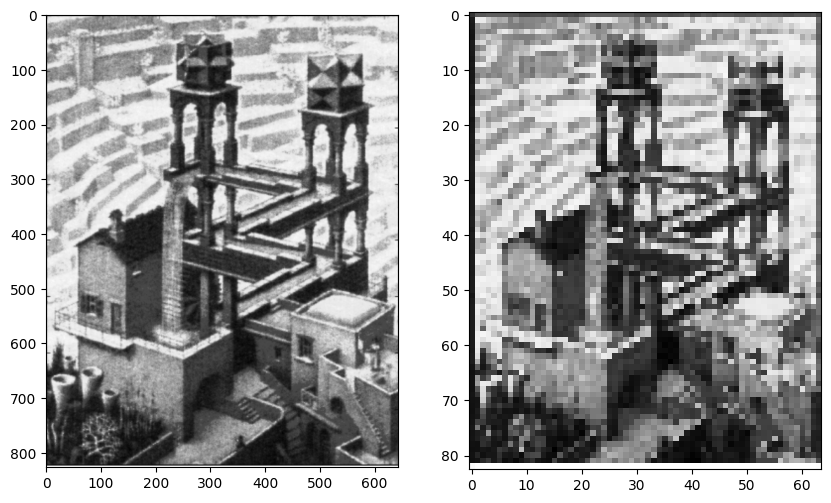

In [19]:
plt.figure(figsize=(10,7))

# original gray image
plt.subplot(1,2,1)
plt.imshow(Xorigray,plt.cm.gray) 

# downsized gray image
plt.subplot(1,2,2)
plt.imshow(X,plt.cm.gray)
plt.show()

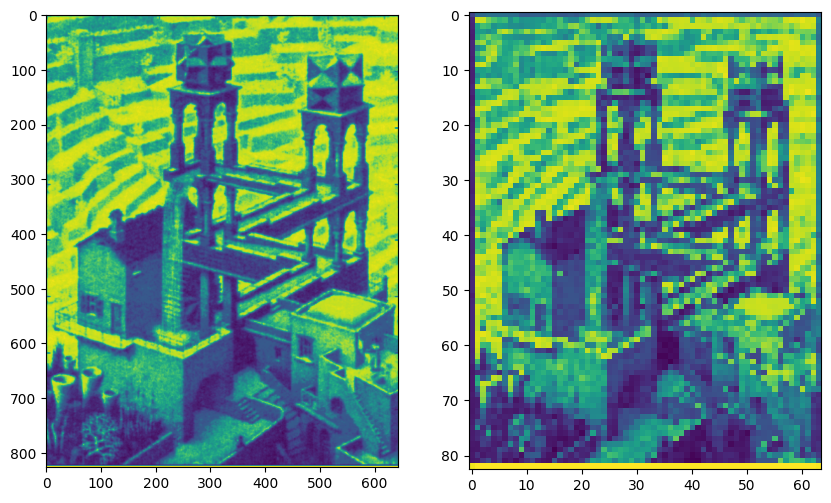

In [21]:
"""
if we don't specify color channel, the showing image will be in color.
"""

plt.figure(figsize=(10,7))

# original gray image
plt.subplot(1,2,1)
plt.imshow(Xorigray) 

# downsized gray image
plt.subplot(1,2,2)
plt.imshow(X)
plt.show()

As in the previous section, we’ll take a random sample of image indices, forming our b matrix. Then, we’ll generate our $A$ matrix.

Creating the $A$ matrix for 2D image data takes a little more ingenuity than it did in the 1D case. In the derivation
that follows, we'll use the Kronecker product $\otimes$ and the fact that the 2D discrete cosine transform is separable to
produce our operator $A$.

Let $X$ be an image in the spectral domain and $D_{i}=i d c t\left(I_{i}\right),$ where $I_{i}$ is the identity matrix of size $i .$ Then:

\begin{align*}
\begin{aligned}
i d c t 2(X) &=i d c t\left(i d c t\left(X^{T}\right)^{T}\right) \\
&=D_{m}\left(D_{n} X^{T}\right)^{T} \\
&=D_{m} X D_{n}^{T}
\end{aligned}
\end{align*}

If $\operatorname{vec}(X)$ is the vector operator that stacks columns of $X$ on top of each other, then:

\begin{align*}
\begin{aligned}
\operatorname{vec}\left(D_{m} X D_{n}^{T}\right) &=\left(D_{n} \otimes D_{m}\right) \operatorname{vec}(X) \\
&=\left(D_{n} \otimes D_{m}\right) x \quad \text { where and } x \equiv \operatorname{vec}(X)
\end{aligned}
\end{align*}

Clearly, the Kronecker product is our desired transformation matrix $\psi$. Therefore, our matrix $A$ becomes $A=\phi\left(D_{n} \otimes D_{m}\right),$ where $\phi$ is the sampling matrix. You can calculate the Kronecker product in Numpy with `numpy.kron`. The main problem with this method is that the Kronecker product can become truly massive very quickly. If your target image is $m$ by $n$ and you're taking $k$ samples, then the $A$ matrix has a size of $(m n k)^{2} .$ That said,
for small images it will be fine.

In [20]:
# extract small sample of signal

# recall definition: (nx, ny) is the shape of the downsized image

k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
# b = np.expand_dims(b, axis=1)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 04 04:18:58 PM: Your problem has 5312 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 04 04:18:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 04 04:18:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 04 04:18:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 04 04:18:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 04 04:18:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

c:\Users\kinla\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Oct 04 04:19:07 PM: Applying reduction ECOS
(CVXPY) Oct 04 04:19:13 PM: Finished problem compilation (took 1.482e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 04 04:19:13 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Oct 04 04:36:40 PM: Problem status: optimal
(CVXPY) Oct 04 04:36:40 PM: Optimal value: 2.236e+00
(CVXPY) Oct 04 04:36:40 PM: Compilation took 1.482e+01 seconds
(CVXPY) Oct 04 04:36:40 PM: Solver (including time spent in interface) took 1.046e+03 seconds


Reconstruct the signal and visualize!

In [21]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# # confirm solution
# if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
#     print('Warning: values at sample indices don\'t match original.')

# create images of mask, where sampled data is colored in white (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 1 
Xm = 1 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

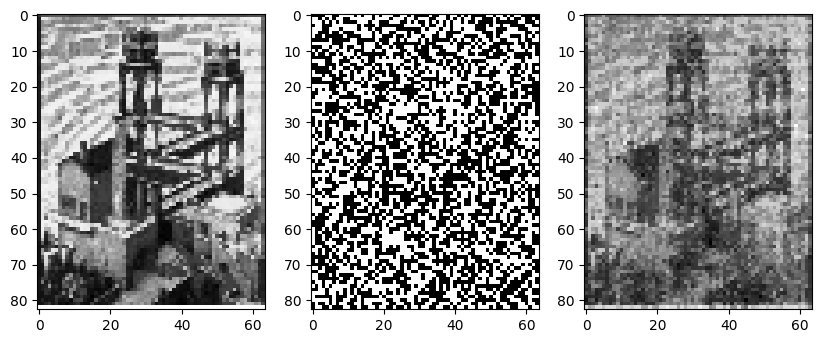

In [22]:
plt.figure(figsize=(10,7))

# original image
plt.subplot(1,3,1)
plt.imshow(X,plt.cm.gray)

# image mask
plt.subplot(1,3,2)
plt.imshow(Xm,plt.cm.gray)

# reconstructed image from sparse samples
plt.subplot(1,3,3)
plt.imshow(Xa,plt.cm.gray)
plt.show()

Okay, the results aren’t fabulous. The original image on the far left is barely intelligible as it is. Resolution was low, so we had to take a large-ish sample of 50% (the boolean mask is shown middle ). Regardless, it is clear the procedure worked: the reconstructed image on the far right definitely approximates the original, be it poorly.

<a href='#top'>jump to the top</a>

## 7.4 Gradient Descent  method<a id='section4'></a>

 Find the local minima of the function $y=(x+5)^2$ starting from the point $x=3$
 
 We know the answer just by looking at the graph. $y = (x+5)^2$ reaches it’s minimum value when $x = -5$ (i.e when $x=-5, y=0$). Hence $x=-5$ is the local and global minima of the function.
 
 Now, let’s see how to obtain the same numerically using gradient descent.
 
 Step 1: Initialize $x=3 .$ Then, find the gradient of the function, $\mathrm{dy} / \mathrm{d} \mathrm{x}=2\times(x+5)$
 
 Step 2 : Move in the direction of the negative of the gradient. But wait, how much to move? For that, we require a learning rate. Let us assume the learning rate → 0.01

Step 3 : Let’s perform 2 iterations of gradient descent

Step 4 : We can observe that the X value is slowly decreasing and should converge to -5 (the local minima). However, how many iterations should we perform?

Let us set a precision variable in our algorithm which calculates the difference between two consecutive “x” values . If the difference between x values from 2 consecutive iterations is lesser than the precision we set, stop the algorithm !

In [23]:
cur_x = 3 # The algorithm starts at x=3
rate = 0.01 # Learning rate
precision = 0.000001 #This tells us when to stop the algorithm
previous_step_size = 1 #
max_iters = 10000 # maximum number of iterations
iters = 0 #iteration counter
df = lambda x: 2*(x+5) #Gradient of our function 

Stop loop when difference between x values from 2 consecutive iterations is less than 0.000001 or when number of iterations exceeds 10,000

In [24]:
while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x #Store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x) #Grad descent
    previous_step_size = abs(cur_x - prev_x) #Change in x
    iters = iters+1 #iteration count
    print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    
print("The local minimum occurs at", cur_x)

Iteration 1 
X value is 2.84
Iteration 2 
X value is 2.6832
Iteration 3 
X value is 2.529536
Iteration 4 
X value is 2.37894528
Iteration 5 
X value is 2.2313663744
Iteration 6 
X value is 2.0867390469119997
Iteration 7 
X value is 1.9450042659737599
Iteration 8 
X value is 1.8061041806542846
Iteration 9 
X value is 1.669982097041199
Iteration 10 
X value is 1.5365824551003748
Iteration 11 
X value is 1.4058508059983674
Iteration 12 
X value is 1.2777337898784
Iteration 13 
X value is 1.152179114080832
Iteration 14 
X value is 1.0291355317992152
Iteration 15 
X value is 0.9085528211632309
Iteration 16 
X value is 0.7903817647399662
Iteration 17 
X value is 0.6745741294451669
Iteration 18 
X value is 0.5610826468562635
Iteration 19 
X value is 0.44986099391913825
Iteration 20 
X value is 0.3408637740407555
Iteration 21 
X value is 0.23404649855994042
Iteration 22 
X value is 0.1293655685887416
Iteration 23 
X value is 0.026778257216966764
Iteration 24 
X value is -0.07375730792737258
It

Output : From the output below, we can observe the x values for the first 10 iterations- which can be cross checked with our calculation above. The algorithm runs for 595 iterations before it terminates.

<a href='#top'>jump to the top</a>

## 7.5 Robust PCA<a id='section4'></a>

- Note that the PCA suffers from outliers and corrupted data
- The robust PCA (RPCA) aims to decompose the data matrix $X$ as follows
$$X=L+S$$
where $L$ is low-rank and $S$ is sparse
- The principal component $L$ is robust to outliers and corrupted data described by $S$

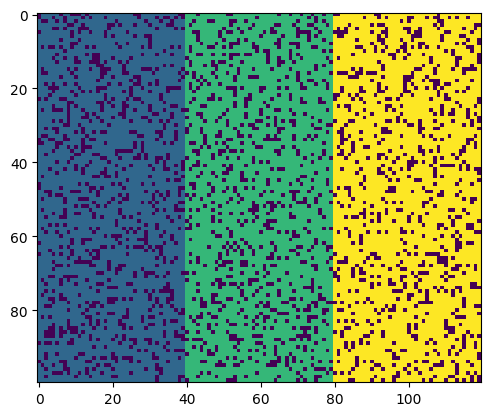

In [35]:
from r_pca import *

# generate low rank synthetic data
N = 100
num_groups = 3
num_values_per_group = 40 # width of the image
p_missing = 0.2 # randomly setting 20% of the values to missing. 

"""creating a mast below
"""
Ds = []
# each step of the loop create a low-rank matrices d. 
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10 # k+1 --> 1,2,3
    Ds.append(d)

D = np.hstack(Ds) 
# horizontally stack the arrays in Ds to D. 
# Results in a data matrix with a mix of different low-rank structures 

# decimate 20% of data 
n1, n2 = D.shape
S = np.random.rand(n1, n2)
D[S < 0.2] = 0
"""end of creating the image
"""

plt.imshow(D)
plt.show()

In [36]:
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)


iteration: 1, error: 6.569312613342032


iteration: 100, error: 0.04536994686553222
iteration: 200, error: 0.02864982803508917
iteration: 300, error: 0.025171541058228077
iteration: 400, error: 0.0252675293559036
iteration: 500, error: 0.04744297088958626
iteration: 600, error: 0.07874405268527046
iteration: 700, error: 0.00444387800221226
iteration: 747, error: 0.00011763752755846401


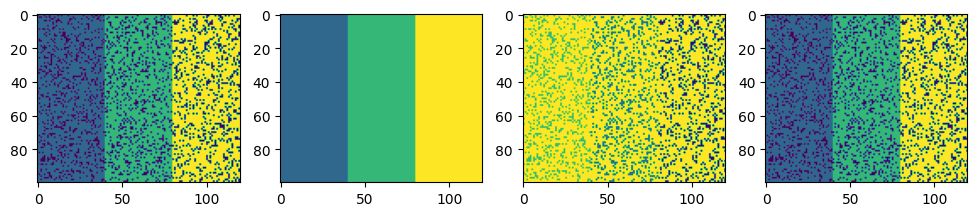

In [37]:
plt.figure(figsize=(12,7))

plt.subplot(1,4,1)
plt.imshow(D)

plt.clim(0,30)
plt.subplot(1,4,2)
plt.imshow(L)

plt.clim(0,30)
plt.subplot(1,4,3)
plt.imshow(S)
plt.subplot(1,4,4)

plt.imshow(S+L)
plt.clim(0,30)

<a href='#top'>jump to the top</a>